In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import glob
from decimal import Decimal
from eofs.xarray import Eof
from bin_functions import bin_TS
from eof_functions import compute_eof, proj_on_eof

In [2]:
plt.style.use('ggplot')

In [3]:
reso = [0.01,0.02,0.025,0.03,0.04,0.05,0.1]
c = 10
deltaS = reso[1]
deltaT = c*deltaS
sbins = np.arange(30,40, deltaS) 
tbins = np.arange(-2, 33, deltaT)
region='global'

In [5]:
# -- Read piControl
dir4D = '/data/ysilvy/CMIP5_annual/4D/'
dsT_piC = xr.open_mfdataset(dir4D+'thetao*piControl*.nc',combine='by_coords',data_vars='minimal',coords='minimal', compat='override')
dsS_piC = xr.open_mfdataset(dir4D+'so*piControl*.nc',combine='by_coords',data_vars='minimal',coords='minimal', compat='override')
dirvol = '/bdd/CMIP5/output/IPSL/IPSL-CM5A-LR/piControl/fx/ocean/fx/r0i0p0/latest/volcello/'
dsvol = xr.open_dataset(dirvol+'volcello_fx_IPSL-CM5A-LR_piControl_r0i0p0.nc')
dsvol = dsvol.reindex(lev=list(dsT_piC.lev))
dsvol = dsvol.drop('j')
dsvol = dsvol.drop('i')
dsvol = dsvol.rename({'j': 'y','i': 'x'})
# -- Bin volume piControl
VpiC = bin_TS(dsS_piC,dsT_piC,dsvol.volcello,sbins,tbins)

In [8]:
VpiC = VpiC.load()

### EOF without reducing

In [9]:
# -- Perform EOF
solver=Eof(VpiC.stack(z=('so_bin', 'thetao_bin')))

In [11]:
pcs = solver.pcs(npcs=3)
eofs = solver.eofs(neofs=3)
variance_frac = solver.varianceFraction()
var1 = variance_frac[0].data*100
var2 = variance_frac[1].data*100
var3 = variance_frac[2].data*100
total_variance = solver.totalAnomalyVariance()
eofs_st_1 = eofs[0,:].unstack('z')
eofs_st_2 = eofs[1,:].unstack('z')
eofs_st_3 = eofs[2,:].unstack('z')

In [12]:
levels = [-1.e-1,-1.e-2,-1.e-3,-1.e-4,-1.e-5,-1.e-6,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2,1.e-1]
levels_str = ['%.0E' % Decimal(str(w)) for w in levels]

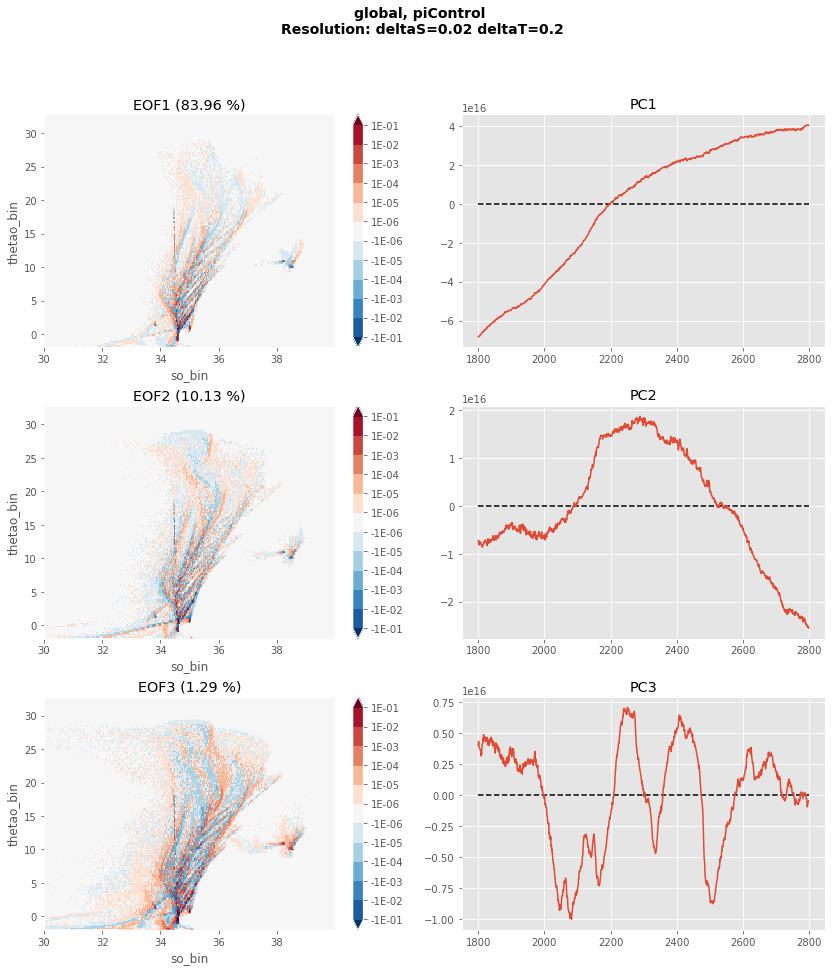

In [16]:
fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

time = np.arange(1800,2800)

c = eofs_st_1.T.plot(ax=ax[0,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0,0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1))+'%)')
ax[0,1].plot(time,pcs[:,0])
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('PC1')

c = eofs_st_2.T.plot(ax=ax[1,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[1,0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[1,0].set_title('EOF2 ('+'%.2f '% Decimal(str(var2))+'%)')
ax[1,1].plot(time,pcs[:,1])
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('PC2')

c = eofs_st_3.T.plot(ax=ax[2,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[2,0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[2,0].set_title('EOF3 ('+'%.2f '% Decimal(str(var3))+'%)')
ax[2,1].plot(time,pcs[:,2])
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('PC3')

plt.subplots_adjust(hspace=0.25,wspace=0.15)
title = region+', piControl \nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT) # \n centered and reduced'

plt.suptitle(title,fontsize=14,fontweight='bold')

plt.savefig('acp_volumeTS_piC_res_'+str(deltaS)+'_'+str(deltaT)+'_'+region+'.png') #002501 #0105

### EOF with the reduction 

In [17]:
def red_zeros(V):
    """Center and reduce array, then replace nans with zeros (nans come from dividing by zero in the reduction)"""
    V_red = V - V.mean(dim='time')
    V_red = V_red/V.std(dim='time')
    V_red = xr.where(np.isnan(V_red)==False,V_red,0)
    return V_red

In [18]:
VpiC_red = red_zeros(VpiC)

In [19]:
# -- Perform EOF
solver_red=Eof(VpiC_red.stack(z=('so_bin', 'thetao_bin')))

In [20]:
pcs_red = solver_red.pcs(npcs=3)
eofs_red = solver_red.eofs(neofs=3)
variance_frac_red = solver_red.varianceFraction()
var1_red = variance_frac_red[0].data*100
var2_red = variance_frac_red[1].data*100
var3_red = variance_frac_red[2].data*100
eofs_st_1_red = eofs_red[0,:].unstack('z')
eofs_st_2_red = eofs_red[1,:].unstack('z')
eofs_st_3_red = eofs_red[2,:].unstack('z')

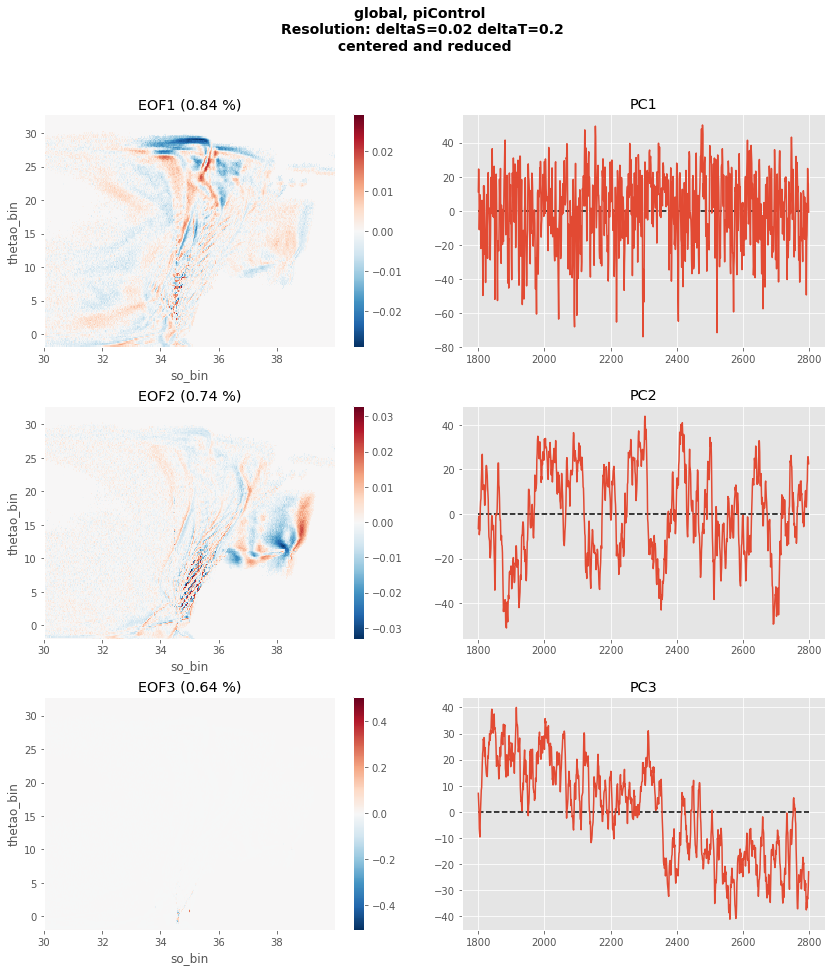

In [22]:
fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

time = np.arange(1800,2800)

c = eofs_st_1_red.T.plot(ax=ax[0,0],cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0,0],label='')
ax[0,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1_red))+'%)')
ax[0,1].plot(time,pcs_red[:,0])
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('PC1')

c = eofs_st_2_red.T.plot(ax=ax[1,0],cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[1,0],label='')
ax[1,0].set_title('EOF2 ('+'%.2f '% Decimal(str(var2_red))+'%)')
ax[1,1].plot(time,pcs_red[:,1])
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('PC2')

c = eofs_st_3.T.plot(ax=ax[2,0],cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[2,0],label='')
ax[2,0].set_title('EOF3 ('+'%.2f '% Decimal(str(var3_red))+'%)')
ax[2,1].plot(time,pcs_red[:,2])
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('PC3')

plt.subplots_adjust(hspace=0.25,wspace=0.15)
title = region+', piControl \nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT) +'\n centered and reduced'

plt.suptitle(title,fontsize=14,fontweight='bold')

plt.savefig('acp_reduced_volumeTS_piC_res_'+str(deltaS)+'_'+str(deltaT)+'_'+region+'.png') #002501 #0105

### EOF not reduced on 251 years 

In [27]:
# -- Perform EOF
solver=Eof(VpiC.sel(time=slice('1860','2110')).stack(z=('so_bin', 'thetao_bin')))

In [28]:
pcs = solver.pcs(npcs=3)
eofs = solver.eofs(neofs=3)
variance_frac = solver.varianceFraction()
var1 = variance_frac[0].data*100
var2 = variance_frac[1].data*100
var3 = variance_frac[2].data*100
total_variance = solver.totalAnomalyVariance()
eofs_st_1 = eofs[0,:].unstack('z')
eofs_st_2 = eofs[1,:].unstack('z')
eofs_st_3 = eofs[2,:].unstack('z')

Text(0.5, 0.98, 'global, piControl \nResolution: deltaS=0.02 deltaT=0.2')

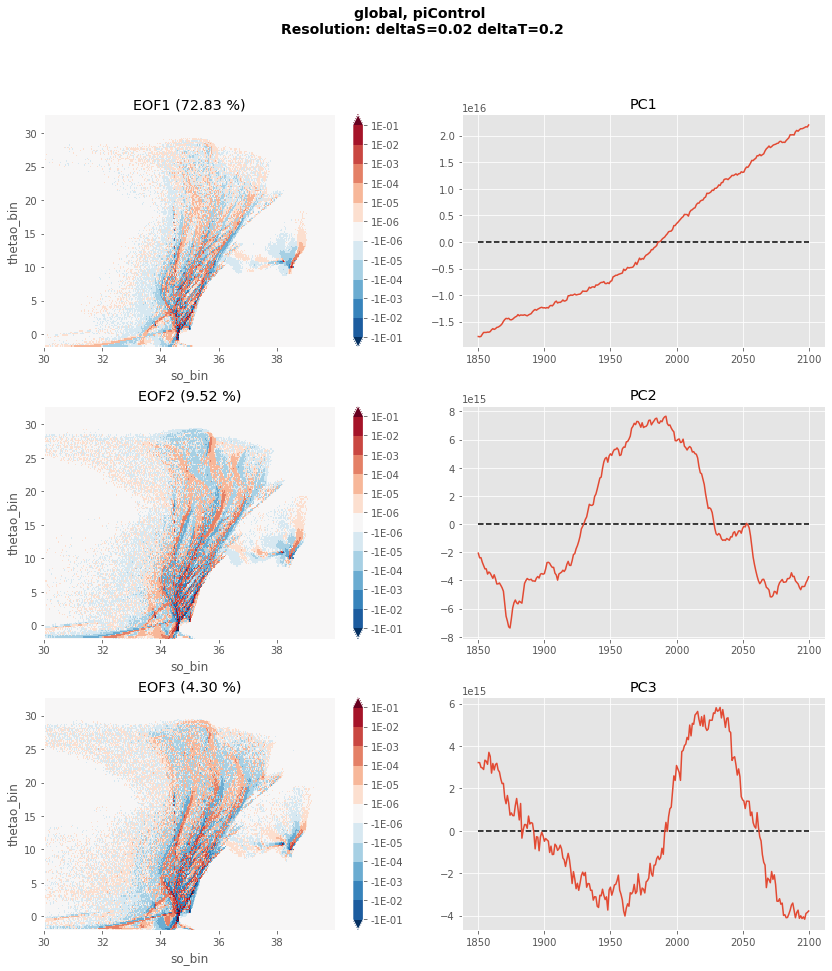

In [29]:
fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

time = np.arange(1860,2111)

c = eofs_st_1.T.plot(ax=ax[0,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0,0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1))+'%)')
ax[0,1].plot(time,pcs[:,0])
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('PC1')

c = eofs_st_2.T.plot(ax=ax[1,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[1,0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[1,0].set_title('EOF2 ('+'%.2f '% Decimal(str(var2))+'%)')
ax[1,1].plot(time,pcs[:,1])
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('PC2')

c = eofs_st_3.T.plot(ax=ax[2,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[2,0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[2,0].set_title('EOF3 ('+'%.2f '% Decimal(str(var3))+'%)')
ax[2,1].plot(time,pcs[:,2])
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('PC3')

plt.subplots_adjust(hspace=0.25,wspace=0.15)
title = region+', piControl \nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT) # \n centered and reduced'

plt.suptitle(title,fontsize=14,fontweight='bold')

# plt.savefig('acp_volumeTS_piC_res_'+str(deltaS)+'_'+str(deltaT)+'_'+region+'.png') #002501 #0105